# Exploratory Data Analysis

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import h5py
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Metadata


In [49]:
train_metadata_path = '/content/drive/My Drive/294P/train-metadata.csv'
test_metadata_path = '/content/drive/My Drive/294P/test-metadata.csv'

train_df = pd.read_csv(train_metadata_path)
test_df = pd.read_csv(test_metadata_path)


<ipython-input-49-230ef36e0cc7>:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_metadata_path)


In [50]:
# Display information about the DataFrame
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [51]:
# Check for missing values
print(train_df.isnull().sum())

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

In [52]:
# Display basic statistics for numerical columns
print(train_df.describe())

              target     age_approx  clin_size_long_diam_mm       tbp_lv_A  \
count  401059.000000  398261.000000           401059.000000  401059.000000   
mean        0.000980      58.012986                3.930827      19.974007   
std         0.031288      13.596165                1.743068       3.999489   
min         0.000000       5.000000                1.000000      -2.487115   
25%         0.000000      50.000000                2.840000      17.330821   
50%         0.000000      60.000000                3.370000      19.801910   
75%         0.000000      70.000000                4.380000      22.304628   
max         1.000000      85.000000               28.400000      48.189610   

         tbp_lv_Aext       tbp_lv_B    tbp_lv_Bext       tbp_lv_C  \
count  401059.000000  401059.000000  401059.000000  401059.000000   
mean       14.919247      28.281706      26.913015      34.786341   
std         3.529384       5.278676       4.482994       5.708469   
min        -9.080269 

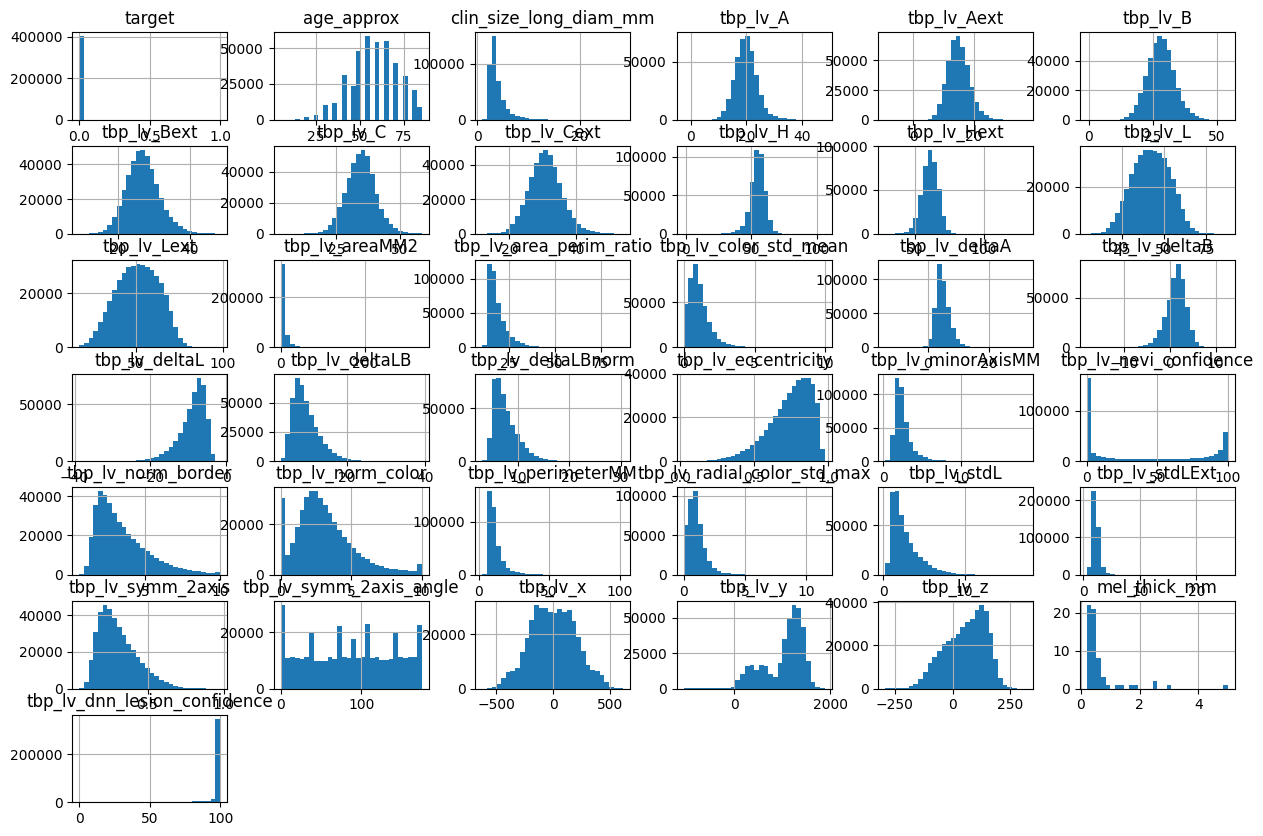

In [53]:
# Histogram for numerical features
train_df.hist(bins=30, figsize=(15, 10))
plt.show()

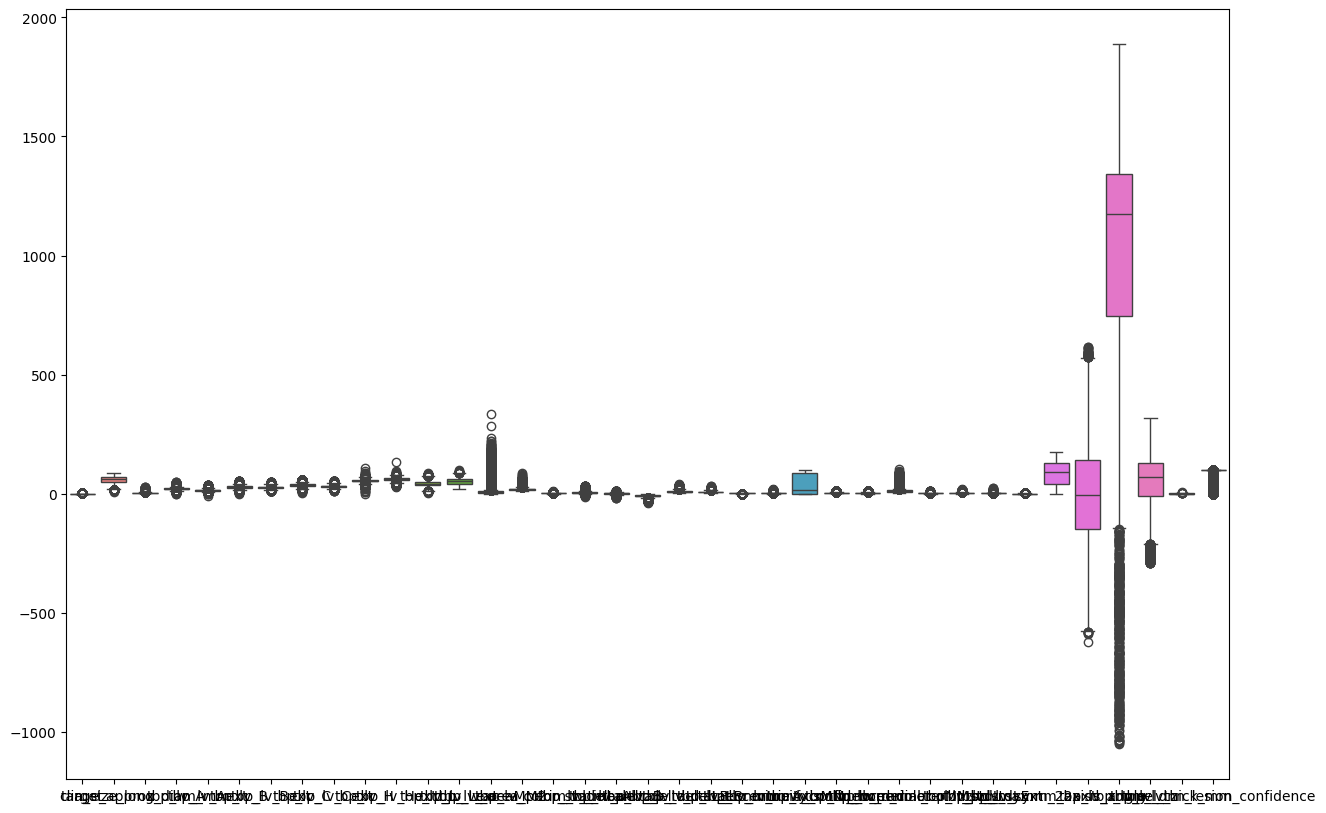

In [54]:
# Box plots for numerical features
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_df.select_dtypes(include=['float64', 'int64']))
plt.show()

### Image data

In [56]:
# Path to the HDF5 file
file_path = '/content/drive/My Drive/294P/train-image.hdf5'

# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    # List all keys (ISIC IDs) in the file
    keys = list(hdf.keys())
    print(f"Number of images: {len(keys)}")

Number of images: 401059


Converted image shape: (139, 139, 3)


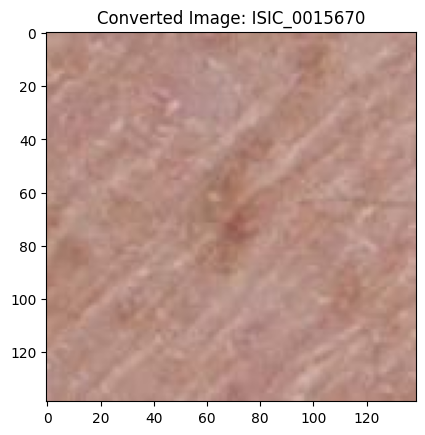

In [57]:
# Convert byte string to image
def bytestring_to_image(byte_string):
    image = Image.open(io.BytesIO(byte_string))
    return np.array(image)

# Open the HDF5 file and convert the first image
with h5py.File(file_path, 'r') as hdf:
    keys = list(hdf.keys())
    first_image_bytes = hdf[keys[0]][()]
    first_image = bytestring_to_image(first_image_bytes)
    print(f"Converted image shape: {first_image.shape}")

    # Visualize the image
    plt.imshow(first_image)
    plt.title(f"Converted Image: {keys[0]}")
    plt.show()



In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print(device)

cuda


# Convolutional Neural Network

In [3]:
import pandas as pd
import numpy as np
import random
import os

# Image Processing
import cv2
from PIL import Image
from io import BytesIO
from sklearn.preprocessing import OneHotEncoder
import h5py

# Evaluation Metrics
from sklearn import metrics

# Deep Learning Modules
from torchvision.io import read_image
from torchvision.models import resnet18
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [7]:
train_file = '/content/drive/My Drive/294P/train-image.hdf5'
train_metadata = pd.read_csv('/content/drive/My Drive/294P/train-metadata.csv')

## selecting the data to be trained
train_metadata_short = train_metadata[['isic_id', 'target']]
train_0 = train_metadata_short.iloc[:400]
train_1 = train_metadata_short.loc[train_metadata_short['target'] == 1]
train_metadata_short = pd.concat([train_0,train_1], axis=0)
train_metadata_short = train_metadata_short.sample(frac=1)

<ipython-input-7-53abb2e96f4e>:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv('/content/drive/My Drive/294P/train-metadata.csv')


In [8]:
def hair_remove(image):
    """Remove hair or similar artifacts from the image."""
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Create kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))

    # Apply blackhat morphology to highlight dark regions on a bright background
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Apply thresholding to create a binary image
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Inpaint original image using the threshold mask
    final_image = cv2.inpaint(image, threshold, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    return final_image

def preprocess_image(image_path, output_path):
    """Load, preprocess, and save an image."""
    # Load image
    image = cv2.imread(image_path)

    # Resize image
    target_size = (256, 256)
    image = cv2.resize(image, target_size)

    # Convert image to RGB (OpenCV loads images in BGR format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize image
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    image_normalized = (image_rgb / 255.0 - mean) / std

    # Adjust contrast using PIL
    image_pil = Image.fromarray((image_rgb * 255).astype(np.uint8))
    enhancer = ImageEnhance.Contrast(image_pil)
    image_contrasted = enhancer.enhance(1.5)

    # Apply augmentations
    augmentations = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30)
    ])
    image_augmented = augmentations(image_contrasted)

    # Convert back to numpy array
    image_augmented_np = np.array(image_augmented)

    # Save preprocessed image
    cv2.imwrite(output_path, cv2.cvtColor(image_augmented_np, cv2.COLOR_RGB2BGR))

# Pre-processing pipeline using Albumentations
transforms_training_albm = A.Compose([
    A.CLAHE(),
    A.Resize(256, 256),
    A.Normalize(),
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent=0.05,
        shear=(-2, 2),
        scale=(0.7, 1.3),
        p=0.5,
        rotate_method='ellipse',
        keep_ratio=True
    ),
    A.Rotate(limit=5, p=0.5, border_mode=1),
    A.Sharpen(p=0.5),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.01, contrast_limit=0.01),
    ToTensorV2()
])

transforms_val_albm = A.Compose([
    A.CLAHE(),
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
# Pre-processing to convert images to greyscale
from albumentations.pytorch import ToTensorV2
transforms_training_albm = A.Compose([
    A.CLAHE(),
    A.Resize(256,256),
    A.Normalize(),
    A.HorizontalFlip(p=0.5),
    A.augmentations.geometric.transforms.Affine(
        translate_percent=0.05,
        shear=(-2, 2),
        scale=(0.7, 1.3),
        p=0.5,
        rotate_method='ellipse',
        keep_ratio=True,
        mode=1
        ),
    A.Rotate(limit=5, p=0.5, border_mode=1),
    A.Sharpen(p=0.5),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.01, contrast_limit=0.01),
    ToTensorV2(),
])

transforms_val_albm = A.Compose([
    A.CLAHE(),
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2(),
])

In [9]:
# Define custom dataset
class SkinCancerDataset(Dataset):
    def __init__(self, df, file_hdf, test=False, transforms=None):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.is_test = test
        if not test:
            self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = np.array( Image.open(BytesIO(self.fp_hdf[isic_id][()])) )

        if self.transforms:
            img = hair_remove(img)
            img = self.transforms(image=img)['image']

        if not self.is_test:
            target = self.targets[index]
        else:
            target = False

        return img, target


In [10]:
# Define CNN model
class SkinCancerCNN(nn.Module):
    def __init__(self):
        super(SkinCancerCNN, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # Binary classification

    def forward(self, x):
        return self.model(x)

In [11]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        corrects = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                corrects += (predicted == labels).sum().item()

        val_accuracy = corrects / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Print final validation accuracy
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Plot accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()



In [12]:
# Creating Dataset and DataLoader for training and validation
dataset_train = SkinCancerDataset(train_metadata_short[:2*len(train_metadata_short)//3], train_file, transforms=transforms_training_albm)
dataloader_train = DataLoader(dataset_train, batch_size=128, shuffle=True)

dataset_val = SkinCancerDataset(train_metadata_short[2*len(train_metadata_short)//3:], train_file, transforms=transforms_val_albm)
dataloader_val = DataLoader(dataset_val, batch_size=128, shuffle=False)

Epoch 1/10, Loss: 0.9833, Train Accuracy: 0.6136, Val Accuracy: 0.4755
Epoch 2/10, Loss: 0.7730, Train Accuracy: 0.6458, Val Accuracy: 0.5283
Epoch 3/10, Loss: 0.6335, Train Accuracy: 0.6970, Val Accuracy: 0.6340
Epoch 4/10, Loss: 0.5559, Train Accuracy: 0.7557, Val Accuracy: 0.6528
Epoch 5/10, Loss: 0.6155, Train Accuracy: 0.7083, Val Accuracy: 0.5283
Epoch 6/10, Loss: 0.5634, Train Accuracy: 0.6951, Val Accuracy: 0.6189
Epoch 7/10, Loss: 0.5806, Train Accuracy: 0.7121, Val Accuracy: 0.4868
Epoch 8/10, Loss: 0.5755, Train Accuracy: 0.7216, Val Accuracy: 0.6528
Epoch 9/10, Loss: 0.5496, Train Accuracy: 0.7330, Val Accuracy: 0.7208
Epoch 10/10, Loss: 0.4964, Train Accuracy: 0.7633, Val Accuracy: 0.7245
Final Validation Accuracy: 0.7245


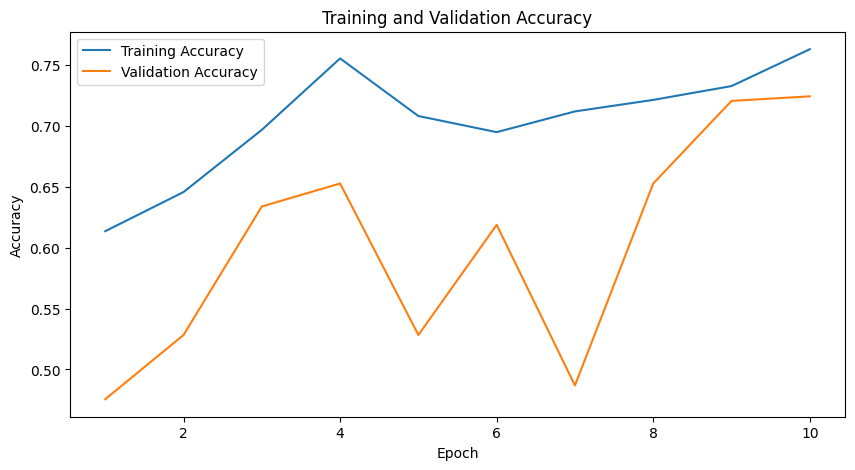

In [14]:
model = SkinCancerCNN()
train_model(model, dataloader_train, dataloader_val)

# Random Forest

In [42]:
def preprocess_metadata(data):
    """Preprocesses the given metadata DataFrame."""

    # Fill missing values
    data['age_approx'] = data['age_approx'].fillna(data['age_approx'].median())
    data['sex'] = data['sex'].fillna('Unknown')
    data['anatom_site_general'] = data['anatom_site_general'].fillna('Unknown')

    # Create new feature
    data['sex_anatom_site'] = data['sex'] + "_" + data['anatom_site_general']

    # Compute mean and std for TBP columns if they exist
    tbp_columns = ['tbp_lv_A', 'tbp_lv_B', 'tbp_lv_C', 'tbp_lv_H', 'tbp_lv_L']
    if all(col in data.columns for col in tbp_columns):
        data['tbp_lv_mean'] = data[tbp_columns].mean(axis=1)
        data['tbp_lv_std'] = data[tbp_columns].std(axis=1)
    else:
        print("Some TBP columns are missing.")

    # Create age groups
    data['age_group'] = pd.cut(data['age_approx'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

    # Compute size to area ratio if columns exist
    if 'clin_size_long_diam_mm' in data.columns and 'tbp_lv_areaMM2' in data.columns:
        data['size_to_area_ratio'] = data['clin_size_long_diam_mm'] / data['tbp_lv_areaMM2']
    else:
        print("'clin_size_long_diam_mm' or 'tbp_lv_areaMM2' column is missing.")

    # Convert categorical variables to dummy variables
    data = pd.get_dummies(data, columns=['sex', 'anatom_site_general', 'image_type', 'tbp_tile_type', 'sex_anatom_site', 'age_group'])

    return data


In [26]:

features = [
    'age_approx',
    'clin_size_long_diam_mm',
    'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
    'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
    'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL',
    'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity',
    'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
    'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max',
    'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'tbp_lv_mean', 'tbp_lv_std',
    'size_to_area_ratio',
    'sex_female', 'sex_male', 'sex_Unknown',
    'anatom_site_general_anterior torso', 'anatom_site_general_head/neck',
    'anatom_site_general_lower extremity', 'anatom_site_general_posterior torso',
    'anatom_site_general_upper extremity', 'anatom_site_general_Unknown',
    'image_type_TBP tile: close-up', 'tbp_tile_type_3D: XP', 'tbp_tile_type_3D: white',
    'sex_anatom_site_female_Unknown', 'sex_anatom_site_female_anterior torso',
    'sex_anatom_site_female_head/neck', 'sex_anatom_site_female_lower extremity',
    'sex_anatom_site_female_posterior torso', 'sex_anatom_site_female_upper extremity',
    'sex_anatom_site_male_Unknown', 'sex_anatom_site_male_anterior torso',
    'sex_anatom_site_male_head/neck', 'sex_anatom_site_male_lower extremity',
    'sex_anatom_site_male_posterior torso', 'sex_anatom_site_male_upper extremity',
    'sex_anatom_site_Unknown_Unknown', 'sex_anatom_site_Unknown_anterior torso',
    'sex_anatom_site_Unknown_head/neck', 'sex_anatom_site_Unknown_lower extremity',
    'sex_anatom_site_Unknown_posterior torso', 'sex_anatom_site_Unknown_upper extremity',
    'age_group_0-20', 'age_group_21-40', 'age_group_41-60', 'age_group_61-80', 'age_group_81-100'
]

In [43]:
train_metadata = pd.read_csv('/content/drive/My Drive/294P/train-metadata.csv')
test_metadata = pd.read_csv('/content/drive/My Drive/294P/test-metadata.csv')
train_metadata = preprocess_metadata(train_metadata)
train_metadata.drop(columns=['iddx_4', 'mel_mitotic_index', 'iddx_1', 'lesion_id', 'tbp_lv_dnn_lesion_confidence',
                    'iddx_5', 'mel_thick_mm', 'iddx_2', 'iddx_full', 'iddx_3'],inplace=True)

<ipython-input-43-41ca5ae05b2c>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv('/content/drive/My Drive/294P/train-metadata.csv')


In [33]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
X_train = train_metadata[features]
y_train = train_metadata['target']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
brf = BalancedRandomForestClassifier(random_state=42)

brf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(random_state=42)

In [34]:
y_pred = brf.predict(X_val_split)
y_pred_prob = brf.predict_proba(X_val_split)[:, 1]

print(f"AUC-ROC: {roc_auc_score(y_val_split, y_pred_prob)}")

AUC-ROC: 0.9922042416021551


In [35]:
accuracy_score(y_val_split, y_pred)

0.8676881264648681

In [24]:
pauc = roc_auc_score(y_val_split, y_pred_prob, max_fpr=0.5)

print(f"Partial AUC (pAUC) up to FPR=0.5: {pauc}")

Partial AUC (pAUC) up to FPR=0.5: 0.9896056554695403


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler


# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_split)
# X_test_scaled = scaler.transform(X_val_split)

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_split, y_train_split)

# Make predictions
y_train_pred = model.predict(X_train_split)
y_test_pred = model.predict(X_val_split)
y_test_prob = model.predict_proba(X_val_split)[:, 1]

# Evaluate model performance
train_accuracy = accuracy_score(y_train_split, y_train_pred)
test_accuracy = accuracy_score(y_val_split, y_test_pred)
test_auc_roc = roc_auc_score(y_val_split, y_test_prob)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test AUC-ROC: {test_auc_roc:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.9990
Test Accuracy: 0.9991
Test AUC-ROC: 0.8802
